In [55]:
import os
import json
from collections import defaultdict
import numpy as np
import scipy.stats
import torch
import pandas as pd
from torch.distributions import constraints
from matplotlib import pyplot
import plotly.express as px
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('0.4.1')
pyro.enable_validation(True)

In [56]:
FILE_DIR = "../"
tmdb_path = os.path.join(FILE_DIR,"data","the-movies-dataset")
movies_metadata_dir = os.path.join(tmdb_path, "movies_metadata.csv")
movies_metadata = pd.read_csv(movies_metadata_dir)
movies_metadata.head()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning:

Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.



,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [51]:
# Data processing for movie genres
movies_metadata['genres'] = movies_metadata['genres'].apply(lambda x: eval(x))
movies_metadata['genres'] = movies_metadata['genres'].apply(lambda x: [genre['name'] for genre in x])
temp = movies_metadata[['id', 'genres']]
movies_genres = (temp['genres']
    .apply(lambda x: pd.Series(x))
    .stack().reset_index(level=1, drop=True)
    .to_frame('genres')
    .join(temp[['id']], how='left')
)
movies_genres.columns = ['genres', 'movieId']
movies_genres = movies_genres.reset_index(drop=True)

In [ ]:
# One hot encoding for movie genres


In [52]:
# Plot movie by genres (Comedy)
comedy_id = movies_genres[movies_genres['genres'] == 'Comedy']['movieId']
comedy_movies = movies_metadata.loc[movies_metadata['id'].isin(comedy_id)]
px.scatter(comedy_movies, x="budget", y="revenue", hover_name="original_title", title="Comedy movies")

In [53]:
# Plot movie by genres (Action)
comedy_id = movies_genres[movies_genres['genres'] == 'Action']['movieId']
comedy_movies = movies_metadata.loc[movies_metadata['id'].isin(comedy_id)]
px.scatter(comedy_movies, x="budget", y="revenue", hover_name="original_title", title="Action movies")

In [54]:
# Plot movie by genres (Horror)
comedy_id = movies_genres[movies_genres['genres'] == 'Horror']['movieId']
comedy_movies = movies_metadata.loc[movies_metadata['id'].isin(comedy_id)]
px.scatter(comedy_movies, x="budget", y="revenue", hover_name="original_title", title="Horror movies")

In [42]:
# Rescale
SCALE = 10 ** 6
movies_metadata['budget'] = pd.to_numeric(movies_metadata['budget'], errors='coerce')

# Must be in float32
data = torch.tensor(np.stack((
    movies_metadata['budget'].values / SCALE, 
    movies_metadata['revenue'].values / SCALE,
    movies_metadata['runtime'],
    movies_metadata['vote_average'],
    movies_metadata['vote_count']), 
    axis=1
), dtype=torch.float32 )

# Take subset of data
data = data[:500]

For $N$ data points, the likelihood is:
\begin{equation}
    p(x_n | \pi, \mu, \sigma^2) = \sum_{k=1}^{K} \pi_k N(x_n | \mu_k, \sigma_k^2)
\end{equation}

Define prior $\pi \in [0,1]$ such that $\sum_{k=1}^{K} \pi_k = 1$
\begin{equation}
    p(\pi) = Dir(\pi | \alpha \mathbb{1}_K)
\end{equation}

for fixed $\alpha = 1$. Prior for each $\mu_k \in \mathbb{R}^D$
\begin{equation}
    p(\mu_k) = Normal(\mu_k | 0, I)
\end{equation}

Prior for each component $\sigma_k^2 \in \mathbb{R}^D$ to be
\begin{equation}
    p(\sigma_k^2) = InvGamma(\sigma_k^2 | a, b)
\end{equation}

In [43]:
# Number of clusters
K = 3

# Number of dimensions
d = 5

def model(data):
    """
    weights: pi
    locs: mean
    scale: variance
    """
    weights = pyro.sample('weights', dist.Dirichlet(torch.ones(K)))
    with pyro.plate('component', K):
        locs = pyro.sample('locs', dist.MultivariateNormal(torch.zeros(d), 1*torch.eye(d)))
        scale = pyro.sample('scale', dist.InverseGamma(1, 1))
    
    with pyro.plate('data', len(data)):
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        
        scale_ = scale[assignment].repeat(d, d, 1).transpose(2, 0)
        scale_ *= torch.eye(d).repeat(len(assignment), 1, 1)   
        
        pyro.sample('obs', dist.MultivariateNormal(locs[assignment], scale_), obs=data)
        
global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scale']))

In [44]:
optim = pyro.optim.Adam({'lr': 0.1})
elbo = TraceEnum_ELBO()
svi = SVI(model, global_guide, optim, loss=elbo)

In [45]:
def initialize(seed):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    loss = svi.loss(model, global_guide, data)
    return loss

# Randomize 100 inits, choose the best
loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print('seed = {}, init loss = {}'.format(seed, loss))

/anaconda3/lib/python3.6/site-packages/pyro/util.py:183: UserWarning:

Found vars in model but not guide: {'assignment'}

/anaconda3/lib/python3.6/site-packages/pyro/infer/traceenum_elbo.py:282: UserWarning:

TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.



seed = 90, init loss = 153034352.0


In [46]:
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(1000):
    loss = svi.step(data)
    losses.append(loss)

/anaconda3/lib/python3.6/site-packages/pyro/util.py:183: UserWarning:

Found vars in model but not guide: {'assignment'}

/anaconda3/lib/python3.6/site-packages/pyro/infer/traceenum_elbo.py:282: UserWarning:

TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.



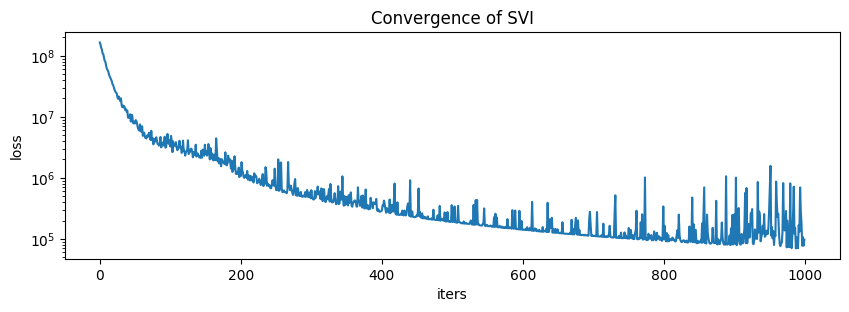

In [47]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

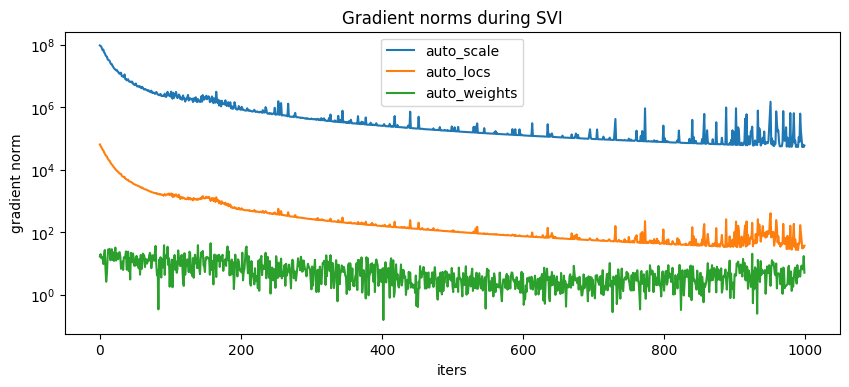

In [48]:
pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');

In [69]:
map_estimates = global_guide(data)
weights = map_estimates['weights']
locs = map_estimates['locs']
scale = map_estimates['scale']
print('weights = {}'.format(weights.data.numpy()))
print('locs = {}'.format(locs.data.numpy()))
print('scale = {}'.format(scale.data.numpy()))

weights = [0.01093699 0.05023329 0.9388297 ]
locs = [[2.007693   2.5904505  3.885709   0.87402856 3.6292913 ]
 [2.3542387  4.079862   4.780103   0.95548004 5.1629167 ]
 [3.0409312  5.9589043  7.36538    1.2262231  7.786663  ]]
scale = [  54.96325  238.32793 4803.2173 ]


Warmup:   0%|          | 0/300 [00:00<?, ?it/s]

RuntimeError: The size of tensor a (15) must match the size of tensor b (5) at non-singleton dimension 1
  Trace Shapes:          
   Param Sites:          
  Sample Sites:          
   weights dist       | 3
          value       | 3
 component dist       |  
          value     3 |  
      locs dist     3 | 5
          value     3 | 5
     scale dist     3 |  
          value     3 |  
      data dist       |  
          value   500 |  
assignment dist   500 |  
          value 3   1 |  